In [1]:
import tables
import numpy as np
import matplotlib.pyplot as plt # for plotting
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'
#from sklearn.metrics import roc_curve

In [3]:
# Create generator class to load data into model when needed (not only into RAM)
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return np.array([
            resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
               for file_name in batch_x])/255.0, np.array(batch_y)

In [4]:
#loop over all input files
filenames = ['9716334.hdf5', '9833127.hdf5', '99196136.hdf5']

# initialze arrays to store images and labels
all_images = np.empty((0, 48,48,1))
all_labels = np.empty((0, 1))

for i in filenames:
    # Open Data File
    #file_path = os.path.join(r'', i)
    x=tables.open_file(i)

    # Filter out electron events
        # Use x.root.event_label[:] != 2 as mask, for all  since electron events are = 2
        # Reshape, in order to add 5th dimension of 1 (1 channel), so that dimension are:
        # [image, telescope, x, y, channel]
    mask_electrons = x.root.event_label[:] != 2

    event_labels = x.root.event_label[:][mask_electrons]
    event_labels = event_labels.reshape((np.shape(event_labels)[0],1))

    squared_training = x.root.squared_training[:,:,:,:][mask_electrons]
    squared_training = squared_training.reshape((*np.shape(squared_training),1))

    peak_times = x.root.peak_times[:,:,:,:][mask_electrons]
    peak_times = peak_times.reshape((*np.shape(peak_times),1))

    # Take first 80 % as training data, remaining 20% as test data
   
    
    # Combine data of all 4 telescopes
    for i in range(0,4):        
        all_images = np.concatenate((all_images,peak_times[:,i,:,:]), axis = 0)
        all_labels = np.concatenate((all_labels,event_labels[:]))
    
    del peak_times # delete arrays, in order to free RAM space
    del squared_training
    del event_labels
print(np.shape(all_images)[0], " images are available")

61004  images are available


In [5]:

# Mask out images where all data is 0

zero_mask = np.sum(all_images, axis = 1) # sums over axis = 1,so from shape (N,48,48,1) to (N,48,1) (along one axis of the image)
zero_mask = np.sum(zero_mask, axis = 1) # sums over axis = 1,so from shape (N,48,1) to (N,1) (along other axis of the image)
zero_mask = np.squeeze(zero_mask) # goes from shape (N,1) to shape (N,)
zero_mask = zero_mask >0 # True/False where sum of whole image is  > 0

non_zero_images = all_images[zero_mask,:,:,:]
non_zero_labels = all_labels[zero_mask]
del zero_mask

print(np.shape(non_zero_images)[0], " images are non zero")


# Split into training data (80%) and test data (20%)
n = int(np.shape(non_zero_images)[0]*0.8)        

train_images = non_zero_images[:n,:,:,:]
train_labels = non_zero_labels[:n]
test_images = non_zero_images[n:,:,:,:]
test_labels = non_zero_labels[n:]
del non_zero_images

print(np.shape(train_images)[0], " images will be used for training")
print(np.shape(test_images)[0], " images will be used for testing")

34036  images are non zero
27228  images will be used for training
6808  images will be used for testing


In [6]:
net = Sequential()

# Conv2D as Convolutional layer 
# MaxPooling2D as Pooling layer after convolution
# Dropout layer to disrupt Neurons to prevent overfitting

net.add(Conv2D(filters=25,kernel_size=[4,4],activation='relu',padding='same',input_shape=(48,48,1)))
net.add(MaxPooling2D(pool_size=2, padding='same'))

net.add(Dropout(0.2))
net.add(Conv2D(filters=50,kernel_size=[3,3],activation='relu',padding='same'))
net.add(MaxPooling2D(pool_size=2, padding='same'))

net.add(Dropout(0.2))
net.add(Conv2D(filters=50,kernel_size=[3,3],activation='relu',padding='same'))
net.add(MaxPooling2D(pool_size=2, padding='same'))

net.add(Dropout(0.2))
net.add(Conv2D(filters=50,kernel_size=[3,3],activation='relu',padding='same'))
net.add(MaxPooling2D(pool_size=2, padding='same'))

net.add(Dropout(0.2))
net.add(Conv2D(filters=100,kernel_size=[3,3],activation='relu',padding='same'))
net.add(MaxPooling2D(pool_size=2, padding='same'))

net.add(Dropout(0.2))
net.add(Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same'))
net.add(MaxPooling2D(pool_size=2, padding='same'))

net.add(Flatten())

net.add(Dropout(0.2))
net.add(Dense(100, activation='relu'))

net.add(Dropout(0.2))
net.add(Dense(50, activation='relu'))


net.add(Dense(2, activation='softmax'))
net.summary()

net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            ,optimizer='adam',metrics=['accuracy'])


history = net.fit(train_images, train_labels, epochs=30, batch_size = 128,
                  validation_data=(test_images, test_labels))

with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 25)        425       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 25)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 50)        11300     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 50)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 50)        0

C:\Users\hanne\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


213/213 [==============================] - 72s 329ms/step - loss: 0.6802 - accuracy: 0.5624 - val_loss: 0.6482 - val_accuracy: 0.6329
Epoch 2/30
213/213 [==============================] - 69s 326ms/step - loss: 0.6439 - accuracy: 0.6401 - val_loss: 0.6176 - val_accuracy: 0.6904
Epoch 3/30
213/213 [==============================] - 69s 323ms/step - loss: 0.6126 - accuracy: 0.6831 - val_loss: 0.5784 - val_accuracy: 0.7131
Epoch 4/30
213/213 [==============================] - 70s 331ms/step - loss: 0.5897 - accuracy: 0.7027 - val_loss: 0.5789 - val_accuracy: 0.7098
Epoch 5/30
213/213 [==============================] - 75s 350ms/step - loss: 0.5802 - accuracy: 0.7103 - val_loss: 0.5856 - val_accuracy: 0.6979
Epoch 6/30
213/213 [==============================] - 54s 252ms/step - loss: 0.5700 - accuracy: 0.7182 - val_loss: 0.5618 - val_accuracy: 0.7183
Epoch 7/30
213/213 [==============================] - 59s 277ms/step - loss: 0.5640 - accuracy: 0.7215 - val_loss: 0.5493 - val_accuracy: 0.7

PermissionError: [Errno 13] Permission denied: '/trainHistoryDict'

In [7]:
import pandas as pd

# assuming you stored your model.fit results in a 'history' variable:

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 


# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [3]:
import pandas as pd

In [4]:
hist_pd = pd.read_csv('history.csv')
print(hist_pd)

    Unnamed: 0      loss  accuracy  val_loss  val_accuracy
0            0  0.680179  0.562436  0.648153      0.632932
1            1  0.643899  0.640150  0.617586      0.690364
2            2  0.612565  0.683120  0.578367      0.713132
3            3  0.589696  0.702659  0.578939      0.709753
4            4  0.580197  0.710335  0.585622      0.697855
5            5  0.570028  0.718158  0.561839      0.718273
6            6  0.563963  0.721537  0.549269      0.734430
7            7  0.559871  0.724401  0.561133      0.720476
8            8  0.548783  0.732591  0.543379      0.731345
9            9  0.549453  0.730718  0.547366      0.728261
10          10  0.541911  0.732408  0.559310      0.723267
11          11  0.542963  0.736778  0.551190      0.725764
12          12  0.536449  0.740965  0.550278      0.726939
13          13  0.533803  0.743463  0.547454      0.730464
14          14  0.530259  0.742691  0.535611      0.741481
15          15  0.529564  0.744381  0.539608      0.7379

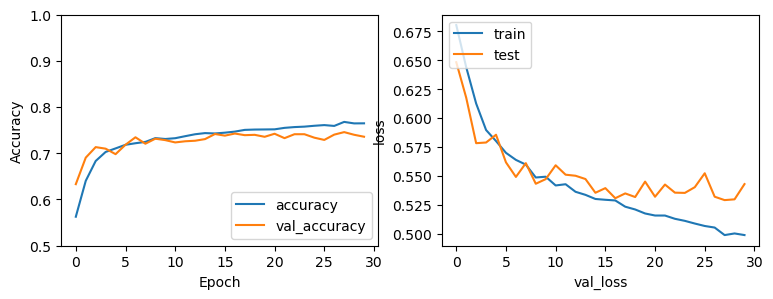

In [5]:
fig, ax = plt.subplots(1,2, figsize = (9,3))
ax[0].plot(hist_pd['accuracy'], label='accuracy')
ax[0].plot(hist_pd['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0.5, 1])
ax[0].legend(loc='lower right')

ax[1].plot(hist_pd['loss'])
ax[1].plot(hist_pd['val_loss'])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('val_loss')
ax[1].legend(['train', 'test'], loc='upper left')
plt.show()           
           
#test_loss, test_acc = net.evaluate(test_images,  test_labels, verbose=2)
fig.savefig('Overview_2022-12-19_30_peaktimes.png', bbox_inches='tight')